In [1]:
import os
import cv2
import time
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits import mplot3d
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score

np.random.seed(42)
warnings.filterwarnings('ignore')

In [3]:
all_data = []
for data_frame in glob.glob("*.csv"):
    data = pd.read_csv(str(data_frame))
    all_data.append(data)

In [4]:
data_select = 2  # Select the data_set between 0, 1, 2, 3
k=15 # Select the number of features to train Random Forest Regressor 

In [37]:
class PcaExplanation:
    
    @staticmethod
    def pca_transform(data):
        scaler = StandardScaler()
        all_data_pca = []
        all_data_norm = []
        surface_tension = []
        n_components = []
        explained_variance = []
        pca_components = []
        pca = PCA(n_components=0.99, svd_solver="auto")
        for i in range(len(data)):
            X = np.array(data[i].iloc[:,2:24])
            scaler.fit(X)
            X_norm = scaler.transform(X)
            all_data_norm.append(X_norm)
            y = np.array(data[i]['surface_tension'])
            surface_tension.append(y)
            pca.fit(X_norm)
            X_pca = pca.transform(X_norm)
            all_data_pca.append(X_pca)
            pca_components.append(pca.components_.T)
            n_components.append(pca.n_components_)
            explained_variance.append(pca.explained_variance_ratio_)
        return all_data_pca, all_data_norm, surface_tension, pca_components, n_components, explained_variance 
    
    @staticmethod
    def plot_2D_features(X_norm, X_pca, data_set_number, file_name=None):
        if data_set_number == 0:
            color_norm = "tomato"
            color_pca = "turquoise"
        elif data_set_number == 1:
            color_norm = "gold"
            color_pca = "#7d1b68"
        elif data_set_number == 2:
            color_norm = "#fa6a02"
            color_pca = "#02faa3"
        elif data_set_number == 3:
            color_norm = "#0f0f0f"
            color_pca = "#690202"
        plt.figure(figsize=(10, 5))
        plt.scatter(X_norm[:, 0], X_norm[:, 1], c=color_norm, alpha=0.5, label='Normalized Data')
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=color_pca, alpha=0.1, label='Data transform PCA')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.title(f'PCA explain with data set {data_set_number}', fontsize=15)
        plt.legend()
        if file_name is not None:
            plt.savefig("PCA_Results/"+f"PCA explain with data set{data_set_number}")
        
    @staticmethod    
    def plot_first_two_pca_features(X_pca, data_set_number, target_values, file_name=None):
        plt.figure(figsize=(12.5, 5))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], edgecolor='none', alpha=0.5, c=target_values)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.colorbar()
        plt.title(f'PCA two first features with data set {data_set_number}', fontsize=15)
        if file_name is not None:
            plt.savefig("PCA_Results/"+f"PCA two first feature with data set{data_set_number}")
        
    @staticmethod
    def plot_3d_pca_features(X_pca, data_set_number, target_values, file_name=None):
        fig = plt.figure(figsize=(8, 6), dpi=80)
        ax = plt.axes(projection='3d')
        ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=target_values)
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
        plt.title(f'PCA 3D Visualitation with data set {data_set_number}', fontsize=15)
        if file_name is not None:
            plt.savefig("PCA_Results/"+f"PCA 3D Visualitation with data set{data_set_number}")
    
    @staticmethod    
    def componets_descriptor(X_pca, data_select, data_set_number, pca_components, file_name=None):
        component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
        X_pca = pd.DataFrame(X_pca, columns=component_names)
        X_pca.head()
        loadings = pd.DataFrame(
            pca_components,
            columns=component_names,
            index=data_select.columns[2:24], 
        )
        if file_name is not None:
            loadings.to_excel("PCA_Results/"+f"PCA loadings with data set{data_set_number}.xls")
        return loadings
    
    @staticmethod
    def plot_variance(n_components, explained_variance, data_set_number, file_name=None):
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))

        # Define color based on the data set number
        colors = ["tomato", "gold", "#02faa3", "#2a4359"]
        color_1 = colors[data_set_number % len(colors)]

        n = n_components
        grid = np.arange(1, n + 1)
        evr = explained_variance
        axs[0].bar(grid, evr, color=color_1)
        axs[0].set_xlabel("Component", fontsize=12)
        axs[0].set_title(f"Explained Variance with data set {data_set_number}", fontsize=14)

        cv = np.cumsum(evr)
        axs[1].plot(np.r_[0, grid], np.r_[0, cv], c=color_1)
        axs[1].set_xlabel("Component", fontsize=12)
        axs[1].set_title(f"Cumulative Variance with data set {data_set_number}", fontsize=14)

        # Adjust the layout
        plt.tight_layout()
        # Save the figure
        if file_name:
            # Ensure the directory exists
            os.makedirs("PCA_Results", exist_ok=True)
            fig.savefig(f"PCA_Results/{file_name}.pdf", format='pdf')
        return axs

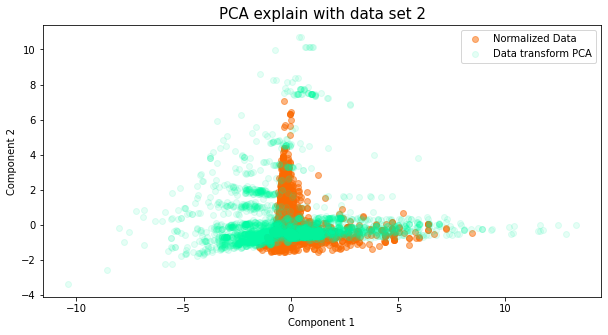

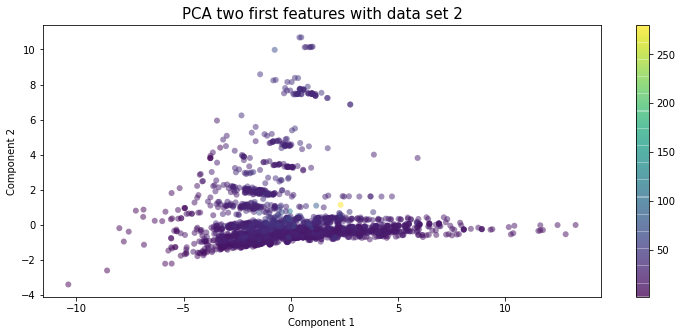

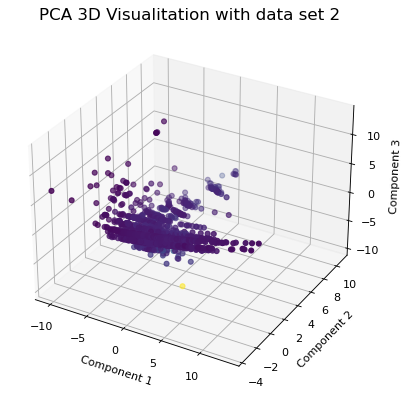

In [38]:
pca_exp = PcaExplanation()
all_data_pca, all_data_norm, target_values, pca_components, n_components, explained_variance = pca_exp.pca_transform(all_data) 
pca_exp.plot_2D_features(all_data_norm[data_select], all_data_pca[data_select], data_select, True)
pca_exp.plot_first_two_pca_features(all_data_pca[data_select], data_select, target_values[data_select], True)
pca_exp.plot_3d_pca_features(all_data_pca[data_select], data_select, target_values[data_select], True)

In [39]:
pca_exp.componets_descriptor(all_data_pca[data_select], all_data[data_select], data_select, pca_components[data_select], True)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
density_liquid,-0.037940,0.647402,-0.025526,-0.046994,0.026038,0.014249,0.013620,0.003313,-0.005708,0.083558,-0.075834,0.024507,0.032207,-0.047108
enthalpy_fusion,0.379366,-0.055210,0.123023,0.007373,0.064890,0.081001,0.069910,0.004233,0.003165,0.125953,-0.113087,0.337721,-0.277976,-0.774623
enthalpy_vaporization,0.412517,0.095110,-0.063946,0.025656,0.038684,-0.009860,-0.020321,-0.012191,-0.000950,0.042240,-0.069957,-0.084704,0.274062,0.036144
enthalpy_vaporization_boiling,0.381680,0.087278,-0.157103,-0.020777,0.052091,-0.069886,0.053072,-0.022876,-0.006203,0.179457,-0.122361,-0.052642,0.672690,-0.028820
thermal_expansion,-0.294046,-0.107266,0.349429,-0.169256,0.158397,-0.006697,0.023022,-0.014147,0.002581,0.117427,0.019485,0.732592,0.376366,0.126809
C,0.395212,-0.158030,0.198062,-0.006233,0.052517,0.027317,-0.002186,0.002272,0.025485,-0.126910,0.064003,-0.011192,0.065330,0.162481
Br,-0.017058,0.441874,-0.013345,-0.158348,-0.145291,0.087423,0.651320,0.003902,0.020711,-0.076576,0.196454,0.108065,-0.112987,0.065455
Cl,-0.097626,0.152409,0.053380,0.636472,0.211555,0.021089,0.033272,-0.004139,0.006407,-0.148603,-0.625927,0.124080,-0.072412,0.130666
O,0.022088,-0.059982,-0.515196,-0.265314,0.484539,-0.409783,0.058528,0.044537,-0.027201,0.311221,-0.128343,0.137892,-0.270155,0.156411
F,-0.114150,0.062662,0.594512,-0.320454,0.293114,0.005513,-0.029412,-0.053225,0.037749,0.335142,-0.229490,-0.460752,-0.067240,-0.029148


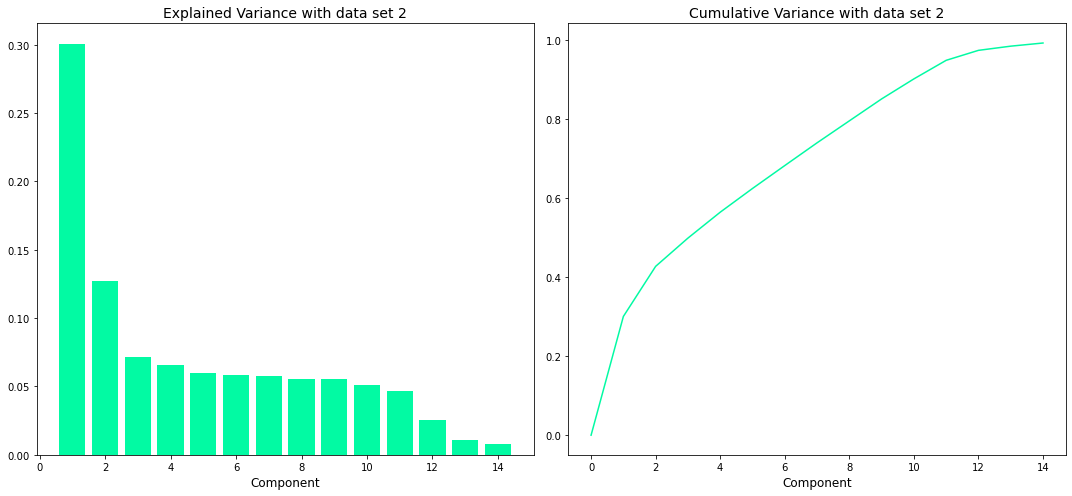

In [40]:
# Dibuja la primera gráfica en el primer subplot
pca_exp.plot_variance(n_components[data_select], explained_variance[data_select], data_select, True)
plt.subplots_adjust(wspace=0.07)

In [158]:
class FeatureXGB:
    
    @staticmethod
    def split(data):
        X = np.array(data.iloc[:,2:24])
        scaler = StandardScaler()
        scaler.fit(X)
        X_norm = scaler.transform(X)
        y = np.array(data['surface_tension'])
        X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.15, random_state=42)
        return X_train, X_test, y_train, y_test
    
    @staticmethod
    def search(hyperparameters, X_train, y_train):
        XGB_regression = RandomForestRegressor()
        search = GridSearchCV(XGB_regression, hyperparameters, cv = 5, verbose=3)
        start_time = time.time()
        parameters = search.fit(X_train, y_train)
        elapsed_time = time.time() - start_time
        print("Elapsed time:", elapsed_time)
        return parameters.best_params_
    
    @staticmethod
    def best_regresor(best_params, X_train, y_train):
        XGB_regression = RandomForestRegressor(**best_params)
        model = XGB_regression.fit(X_train, y_train)
        return model
    
    @staticmethod
    def feature_importance(model,  X_train, y_train):
        result = permutation_importance(model, X_train, y_train, n_repeats=10,
                                    random_state=0)
        return result


In [159]:
xgb = FeatureXGB()
X_train, X_test, y_train, y_test = xgb.split(all_data[data_select])
hyperparameters = {'max_features': ["sqrt","log2"],
                  'n_estimators': [int(x) for x in np.linspace(start=1, stop=50, num=10)],
                  'max_depth': [int(x) for x in np.linspace(1, 110, num=10)],
                  'min_samples_split': [2, 4, 5, 6],
                  'min_samples_leaf': [1, 2, 4, 8],
                  "bootstrap": [True]}
best_params = xgb.search(hyperparameters, X_train, y_train)
model = xgb.best_regresor(best_params, X_train, y_train)
result = xgb.feature_importance(model,  X_train, y_train)

Fitting 5 folds for each of 3200 candidates, totalling 16000 fits
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.159 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.421 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=-0.048 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.209 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.182 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.203 total time=   0.0s
[CV 2/5] END bootstrap=True, max_

[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.342 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.423 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.242 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.315 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.278 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.315 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_s

[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.225 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.281 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.294 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.364 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.427 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.274 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.321 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.312 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.350 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.376 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.234 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.224 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.280 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.303 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.329 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.396 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.276 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.293 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.287 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.286 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.292 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.042 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.011 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=-0.102 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_spli

[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.374 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.231 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.304 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.250 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.364 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.371 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.280 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.323 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.366 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.403 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.266 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.258 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.329 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.336 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.391 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.247 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.294 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.312 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.278 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.321 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.339 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.382 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.279 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.303 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.355 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.315 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.302 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.332 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.372 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.341 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.258 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=17;, score=0.280 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.381 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.404 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.205 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.292 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.270 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.289 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.326 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.306 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.261 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.287 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_s

[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.301 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.328 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.340 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.258 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.303 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.314 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.291 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.279 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.333 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.361 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.257 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.242 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_s

[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.255 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.271 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.323 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.211 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.394 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.161 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_spli

[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.369 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.419 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.236 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.321 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.311 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.361 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_s

[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.326 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.389 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.246 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.309 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.318 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.355 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_s

[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.363 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.398 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.265 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.297 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.283 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.356 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_s

[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.279 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.346 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.385 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.259 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.283 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.327 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_s

[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.338 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.283 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.284 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.259 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.284 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.351 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_s

[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.372 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.280 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.298 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.310 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.341 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.384 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_s

[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.393 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.247 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.287 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.283 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.368 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.420 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_s

[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.375 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.268 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.302 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.269 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.338 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.363 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_s

[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.270 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.362 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.343 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.253 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.277 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.284 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_s

[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.266 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.323 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.283 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.310 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.418 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.244 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.282 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.309 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.329 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.399 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.252 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.318 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.742 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.874 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.894 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.757 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.695 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.769 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.850 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.883 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.747 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.644 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.745 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.646 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.746 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.847 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.871 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.782 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.689 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.875 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.399 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.534 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.533 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.605 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=-0.082 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_sample

[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.798 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.677 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.701 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.834 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=11;, score=0.831 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples

[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.737 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.697 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.732 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.782 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.798 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.752 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.714 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.806 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.853 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.750 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.698 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.748 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.775 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.629 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.704 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.805 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.825 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.769 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.628 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.752 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.809 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.805 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.739 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.642 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.649 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.775 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.819 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.821 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.761 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.668 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.762 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.662 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.735 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.850 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.832 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.743 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.775 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.724 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.596 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.699 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.802 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.654 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_sam

[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.742 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.581 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.709 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.855 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.754 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=22;, score=0.730 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.742 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.751 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.603 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.688 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.786 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.762 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.906 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.753 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.666 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.740 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.859 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=39;, score=0.859 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.699 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.734 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.866 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.869 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.772 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.699 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.752 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.829 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.868 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.757 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.686 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.710 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.767 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.861 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.740 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.475 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.356 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=1;, score=0.564 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_sample

[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=-0.045 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.170 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.910 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.682 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.673 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=6;, score=0.787 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples

[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.673 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.733 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.887 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.869 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.757 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.682 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.694 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.730 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.832 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.850 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.765 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.669 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=2, min_sa

[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.730 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.629 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.724 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.815 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.816 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.764 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.726 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.834 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.809 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.752 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.675 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_sa

[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.836 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.591 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.639 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.366 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.595 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.651 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=4, min_samples

[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.599 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.693 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.773 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.763 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.722 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.572 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_sa

[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.678 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.798 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.775 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.679 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.630 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.672 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_sa

[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.568 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.713 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.791 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.766 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.719 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.602 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.747 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.736 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.607 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.709 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.809 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.731 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=13, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.830 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.771 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.701 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.734 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.879 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.909 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.881 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.784 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.692 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.774 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.877 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.502 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_sam

[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.657 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.640 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.648 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.676 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.869 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=11;, score=0.742 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_sample

[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.762 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.735 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.731 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.762 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.849 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.768 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.743 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=17;, score=0.828 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.862 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.763 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.668 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=22;, score=0.750 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.676 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.730 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=28;, score=0.843 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.817 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.771 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.702 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.755 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.688 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.738 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.832 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.822 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.760 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.837 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.820 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.754 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.672 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.722 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.827 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.778 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.650 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.743 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.823 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.603 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.456 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samp

[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.739 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.656 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.715 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=17;, score=0.795 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.836 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.740 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.738 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.740 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.586 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.672 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.749 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.752 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.601 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.681 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.800 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.777 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.751 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.590 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.737 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.613 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.674 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.800 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.759 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.739 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.746 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.741 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.583 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.697 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.787 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.763 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.843 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.898 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.763 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.702 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.752 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.862 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.738 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.873 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.602 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.340 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.518 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.254 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_sample

[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.702 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.861 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.863 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.746 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.685 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.765 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.777 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.689 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.732 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.853 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.847 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.753 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.862 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.750 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.695 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.750 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.872 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.843 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.719 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.867 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.846 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.758 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.668 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.722 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.662 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.601 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.839 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.797 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.697 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.664 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_sampl

[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.830 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.804 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.735 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.681 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.726 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.836 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.651 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.692 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.822 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.824 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.741 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.655 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_sa

[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.822 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.798 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.741 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.675 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.680 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.840 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_sa

[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.782 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.767 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.733 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.572 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.720 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.809 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.803 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.741 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.744 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.600 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.691 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.798 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.817 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.476 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.288 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.419 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.574 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.248 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=8, min_samples

[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.715 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.689 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.790 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6;, score=0.767 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.868 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=11;, score=0.773 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_sample

[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.752 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.833 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.914 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.768 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.697 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.871 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.761 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.690 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.884 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.903 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.654 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.724 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.868 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.884 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.776 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.680 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.679 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.744 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.856 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.855 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.775 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.707 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.761 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.696 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.685 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.869 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.840 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.763 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.726 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.872 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.635 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.516 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.515 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.454 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=2, min_sample

[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.795 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.817 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.738 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.661 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.702 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.825 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.799 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.745 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.664 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.737 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.807 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.827 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.647 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.696 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.807 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.816 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.742 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.679 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.718 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.858 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.807 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.746 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.670 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.711 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.756 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.721 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.612 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.696 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.790 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.577 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_sam

[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.746 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.736 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.741 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.723 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.571 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=17;, score=0.698 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.731 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.738 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.613 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.643 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.814 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=28;, score=0.746 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.826 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.885 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.766 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.715 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.719 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.900 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_sa

[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.857 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.883 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.773 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.707 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.715 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.885 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_sa

[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.858 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.871 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.761 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.659 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.752 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.847 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.890 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.771 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.657 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.749 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.865 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.870 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.779 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.690 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.711 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.885 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.322 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.329 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samp

[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.702 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.707 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.696 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=11;, score=0.767 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.836 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.737 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.707 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.864 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.865 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.737 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.683 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.741 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.756 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.823 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.784 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.770 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.681 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=28;, score=0.708 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.668 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.741 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.820 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.822 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.756 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.687 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.660 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.722 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.828 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.832 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.758 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.654 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.717 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.846 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.814 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.763 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.629 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.716 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.687 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.757 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.767 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.743 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.595 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.697 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.807 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.637 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.512 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.447 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.531 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.376 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples

[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.705 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.806 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.752 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.703 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.573 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.730 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=37, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.855 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.897 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.795 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.713 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.744 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.817 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.784 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.687 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.755 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.860 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.854 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.735 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.777 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.677 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.766 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.897 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.881 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.779 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.762 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.878 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.894 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.747 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.673 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.734 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.742 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.865 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.653 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.293 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.549 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.617 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_sample

[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.727 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.774 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.859 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.747 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.730 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.719 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.769 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.678 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.733 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.848 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.833 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.747 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.807 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.744 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.638 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.721 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.851 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=44;, score=0.801 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.664 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.724 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.828 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.801 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.753 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.678 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.836 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.766 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.468 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.463 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.588 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.444 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=4, min_samples

[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.569 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.697 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.760 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.761 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.733 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=22;, score=0.600 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.582 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.705 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.756 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.769 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.772 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=33;, score=0.613 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.794 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.762 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.729 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.610 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.696 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.797 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.689 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.773 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.765 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.739 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.598 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.688 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.871 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.883 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.750 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.696 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.760 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.880 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.628 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.690 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=11;, score=0.738 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.893 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.758 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.659 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.737 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=17;, score=0.842 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.885 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.762 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.631 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=22;, score=0.773 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.660 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.730 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=28;, score=0.826 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.848 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.754 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=33;, score=0.681 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.875 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.775 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.699 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.761 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=39;, score=0.855 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.872 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.750 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=44;, score=0.843 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.849 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.781 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.680 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.758 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_sa

[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.869 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1;, score=0.570 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1;, score=0.579 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1;, score=0.566 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1;, score=0.452 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=1;, score=0.637 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples

[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.834 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.829 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.728 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.667 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.737 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.852 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.792 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.745 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.672 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.721 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.857 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.766 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.725 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.806 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.796 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.762 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.658 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.730 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.741 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.716 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.581 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.676 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.775 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.778 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.766 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.734 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.608 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.709 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.807 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.475 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_sam

[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=6;, score=0.696 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=6;, score=0.747 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.723 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.704 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.545 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.674 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=49, max_features=log2, min_samples_leaf=8, min_samp

[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.864 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.843 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.719 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.669 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.716 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.862 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.841 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.887 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.763 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.678 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.754 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.847 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.658 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.702 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.841 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.894 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.749 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.680 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.769 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.675 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.758 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.869 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.863 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.765 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.739 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.867 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.861 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.764 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.725 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.743 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.850 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.498 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=-0.004 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.778 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.604 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.555 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_sample

[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.207 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=6;, score=0.794 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=6;, score=0.667 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=6;, score=0.668 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=6;, score=0.713 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=6;, score=0.749 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=2, min_samples_

[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.562 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.738 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.790 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.788 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.692 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.606 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.603 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.745 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.800 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.760 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.763 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.644 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.680 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.722 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.826 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.820 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.741 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.640 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.719 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.814 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.821 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.763 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.647 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.750 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.615 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.700 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.798 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.747 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.721 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.595 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.587 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.670 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.825 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.764 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.742 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.615 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.747 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.602 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.598 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.495 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.673 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=1;, score=0.733 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=sqrt, min_samples_leaf=8, min_samples

[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.708 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.841 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.882 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.750 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.732 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.732 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.703 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.864 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.915 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.770 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.700 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.715 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.692 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.738 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.845 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.855 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.747 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.688 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.768 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.690 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.731 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.875 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.841 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.771 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.733 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.709 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.739 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.862 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.840 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.778 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_sa

[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.760 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.697 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.731 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.862 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.713 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.254 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samp

[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.599 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.713 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.831 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.848 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.747 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.657 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=2, min_sa

[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.759 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.630 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.660 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.771 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.830 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.752 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.833 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.746 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.656 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.697 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.846 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.808 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.803 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.734 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.632 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.700 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.794 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.816 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.804 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.734 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.625 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.710 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.839 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.820 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.745 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.746 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.596 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.678 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.794 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.743 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.766 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.730 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.605 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.687 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.815 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.758 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.780 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.763 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.732 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.604 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.723 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.792 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_sa

[CV 4/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.694 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=61, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.795 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.272 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=-0.364 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.148 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.421 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_sampl

[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.800 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.763 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.724 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.692 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.850 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.843 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.739 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.860 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.883 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.765 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.640 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.701 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.765 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.705 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.732 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.844 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.873 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.773 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.735 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.847 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.867 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.736 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.689 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.723 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.740 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.856 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.844 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.738 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.698 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.753 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.858 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.601 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.564 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.484 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.687 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.447 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=2, min_samples

[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.737 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.676 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.726 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.824 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.802 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.733 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.635 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.743 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.806 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.816 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.744 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.660 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.647 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.737 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.831 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.816 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.715 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.645 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.716 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.854 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.798 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.737 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.638 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.713 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.759 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.731 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.605 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.674 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.782 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.767 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.682 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.805 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.590 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.642 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.409 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.493 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_sample

[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.580 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.676 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.742 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.748 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.732 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.590 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.666 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.897 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.894 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.727 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.684 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.761 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.759 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.846 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.896 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.762 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.689 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.720 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.876 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.776 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.696 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.746 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.846 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.884 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.772 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.687 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.713 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.854 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.866 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.755 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.760 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.693 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.732 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.860 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.752 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.411 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samp

[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.700 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.838 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.835 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.744 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.664 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.747 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.710 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.834 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.844 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.772 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.710 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=33;, score=0.727 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.655 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.675 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.832 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.822 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.748 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.636 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.768 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.654 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.727 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.836 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.810 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.755 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_sa

[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.853 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.821 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.768 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.658 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.750 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.853 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.695 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.723 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.746 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.732 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.562 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.702 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_sa

[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.718 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.596 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.680 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.705 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.747 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.740 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.758 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.756 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.724 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.597 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.670 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.793 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=33;, score=0.740 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.756 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.718 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.599 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.663 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.738 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=73, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.892 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.754 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.648 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.745 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.844 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.886 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.795 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.683 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.734 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.851 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.725 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=-0.688 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_sam

[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.260 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.700 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.753 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.802 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.723 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=6;, score=0.689 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=1, min_samples_

[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=11;, score=0.825 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.843 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.747 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.725 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.712 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.865 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.872 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.758 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.695 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.765 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.834 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=33;, score=0.837 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.714 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.842 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.840 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.747 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.687 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.727 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.844 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.755 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.687 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.755 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.846 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=0.829 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.811 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.766 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.640 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.725 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.849 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1;, score=0.770 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_sam

[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.757 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.658 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.725 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.825 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.793 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.734 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.691 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.801 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.821 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.721 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.641 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.596 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.684 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.772 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.758 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.749 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.589 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.733 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.598 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.726 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.802 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.743 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.746 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.764 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.745 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.620 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.701 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.797 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.752 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.799 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.762 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.737 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.593 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.689 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.804 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.771 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.854 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.689 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.681 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.541 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.404 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_sample

[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.808 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=17;, score=0.819 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.889 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.750 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.684 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=22;, score=0.718 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.741 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.653 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.713 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=28;, score=0.839 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.852 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.773 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.859 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.760 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.663 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.765 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.848 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.834 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.716 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.727 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=44;, score=0.848 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.880 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.753 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.688 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_sa

[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.687 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.729 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.846 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.594 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.592 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.305 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=2, min_sampl

[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.753 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.607 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.690 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=6;, score=0.762 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.805 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=11;, score=0.735 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_sample

[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.782 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.754 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.687 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.710 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=17;, score=0.820 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.819 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.824 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.730 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.640 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.717 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.819 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.795 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.821 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.743 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.672 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.735 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.832 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.831 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=4, min_sa

[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.767 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.770 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.745 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.602 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.694 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.797 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.796 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.757 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.746 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.605 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.682 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.813 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.777 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.740 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.724 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.576 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.703 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.827 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_sa

[CV 4/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.690 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=85, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.789 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.694 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.560 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.296 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.569 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_sample

[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.698 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.606 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.728 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=17;, score=0.837 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.853 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.758 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.864 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.783 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.663 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.752 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=28;, score=0.872 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.900 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.760 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=33;, score=0.857 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.838 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.743 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.682 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.720 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=39;, score=0.867 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.861 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.760 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.680 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.726 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=44;, score=0.857 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.831 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.781 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.678 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.739 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.894 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.444 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_sam

[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.757 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.615 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.682 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.833 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.833 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.723 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.864 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.825 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.736 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.648 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.718 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.809 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.664 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=22;, score=0.847 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.802 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.742 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.654 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.712 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.650 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.701 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=28;, score=0.796 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.808 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.757 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=33;, score=0.646 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.752 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.685 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.745 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=33;, score=0.837 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.814 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=39;, score=0.730 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=39;, score=0.808 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.754 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.700 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.603 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.699 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=44;, score=0.792 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.697 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.777 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.760 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.731 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.617 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.692 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=6;, score=0.702 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=6;, score=0.746 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.759 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.729 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.608 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=11;, score=0.714 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=sqrt, min_samples_leaf=8, min_samp

[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.735 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=17;, score=0.908 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.895 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.728 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.667 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=22;, score=0.728 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.752 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=22;, score=0.858 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.906 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.772 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.700 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=28;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_sa

[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.762 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.673 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.761 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=33;, score=0.864 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.879 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.774 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_sa

[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.755 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=39;, score=0.863 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.851 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.731 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.681 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.738 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.877 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.770 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.698 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.723 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.854 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.593 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_sam

[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=0.864 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.559 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.695 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.342 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.580 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=1;, score=0.538 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples

[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.640 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.780 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=11;, score=0.852 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.838 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.743 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=17;, score=0.645 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=2, min_sa

[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=17;, score=0.830 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.810 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.727 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.675 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.698 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=22;, score=0.762 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_sa

[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=28;, score=0.838 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.788 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.747 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.675 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.706 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=33;, score=0.836 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.648 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.706 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=39;, score=0.801 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.830 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.734 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.627 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.743 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.647 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.711 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=44;, score=0.851 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.825 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.753 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.755 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.727 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.623 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.715 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=50;, score=0.815 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=1;, score=0.523 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_sam

[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.578 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.588 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=6;, score=0.650 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.781 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.730 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=11;, score=0.615 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_sampl

[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=17;, score=0.753 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.744 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.738 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.623 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.688 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=22;, score=0.762 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=97, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.859 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.739 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.677 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.783 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=28;, score=0.888 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=33;, score=0.858 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1,

[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.867 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.762 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.688 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.734 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=33;, score=0.854 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=39;, score=0.868 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1,

[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.755 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.666 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.708 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=39;, score=0.888 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.855 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=44;, score=0.751 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1,

[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.700 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.716 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=44;, score=0.835 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.879 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.771 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=0.689 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1,

[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.701 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.735 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.861 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.562 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.622 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.526 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, mi

[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.716 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=17;, score=0.848 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.812 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.740 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.699 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=22;, score=0.751 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2,

[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.735 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=22;, score=0.846 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.857 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.756 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.663 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=28;, score=0.719 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2,

[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.653 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=33;, score=0.823 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.784 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.734 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=39;, score=0.647 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4,

[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.726 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.657 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.712 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=39;, score=0.846 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.818 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=44;, score=0.729 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4,

[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=44;, score=0.841 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.807 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.745 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.664 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.705 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.818 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4,

[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.626 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.697 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=11;, score=0.669 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.761 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.684 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=17;, score=0.601 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8,

[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.757 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.728 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.613 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.693 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=22;, score=0.791 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=28;, score=0.771 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8,

[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.733 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.620 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.682 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=28;, score=0.780 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.755 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=33;, score=0.742 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8,

[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.776 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.727 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.593 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.685 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=39;, score=0.790 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=44;, score=0.766 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8,

[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.881 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.779 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.706 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.764 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=44;, score=0.873 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.883 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1,

[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=44;, score=0.869 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.907 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.764 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.703 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.733 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.865 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1,

[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.860 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.645 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.430 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.460 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.631 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.514 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_

[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.655 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.775 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=17;, score=0.858 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.837 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.764 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=22;, score=0.687 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.738 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.681 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.731 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=28;, score=0.851 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=33;, score=0.871 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=33;, score=0.774 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.667 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.723 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=33;, score=0.871 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.855 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.778 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=39;, score=0.676 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.681 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.760 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=39;, score=0.875 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.843 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.757 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=44;, score=0.675 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.803 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.758 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.661 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.723 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.847 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1;, score=0.564 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, 

[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.798 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.642 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.723 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=17;, score=0.854 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.820 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=22;, score=0.739 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4,

[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.624 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.740 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=22;, score=0.824 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.822 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.739 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=28;, score=0.637 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4,

[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=28;, score=0.743 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.746 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.733 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.602 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.670 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=33;, score=0.834 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8,

[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.762 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.736 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.597 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.682 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=39;, score=0.821 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=44;, score=0.743 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8,

[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=39;, score=0.767 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.760 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.749 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.596 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.689 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=44;, score=0.789 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8,

[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.598 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.711 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.823 total time=   0.0s
Elapsed time: 460.6840841770172


In [160]:
from matplotlib.pyplot import figure
def compute_percentual_importance(importances):
    importance = importances
    mean = importance.importances_mean
    tot = sum(mean)
    hist=[]
    for i in range(len(mean)):
        clc = (mean[i]*100)/tot
        hist.append(clc)
    return hist

def plot_feature_importance(hist, data_set_number, data, algorithm_name):
    if data_set_number == 0:
        color_1 = "tomato"
    elif data_set_number == 1:
        color_1 = "gold"
    elif data_set_number == 2:
        color_1 = "#2a4359"
    elif data_set_number == 3:
        color_1 = "#02faa3"
    labels= [x for x in range(len(list(data.columns)[2:24]))]
    col_names = list(data.columns)[2:24]
    legend_labels = [f'{num}: {col}' for num, col in enumerate(col_names)]
    legend_handles = [plt.Rectangle((0, 0), 0, 0, color=color_1) for _ in col_names]
    figure(figsize=(8, 6), dpi=200)
    plt.bar(labels, hist, color=color_1)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Importance percentage %', fontsize=12)
    plt.xticks(range(len(hist)))
    plt.legend(legend_handles, legend_labels, prop={'size': 8})
    plt.savefig(f"Feature_importance_with_{algorithm_name}_data_set_number_{data_set_number}.png", dpi=300)
    return labels

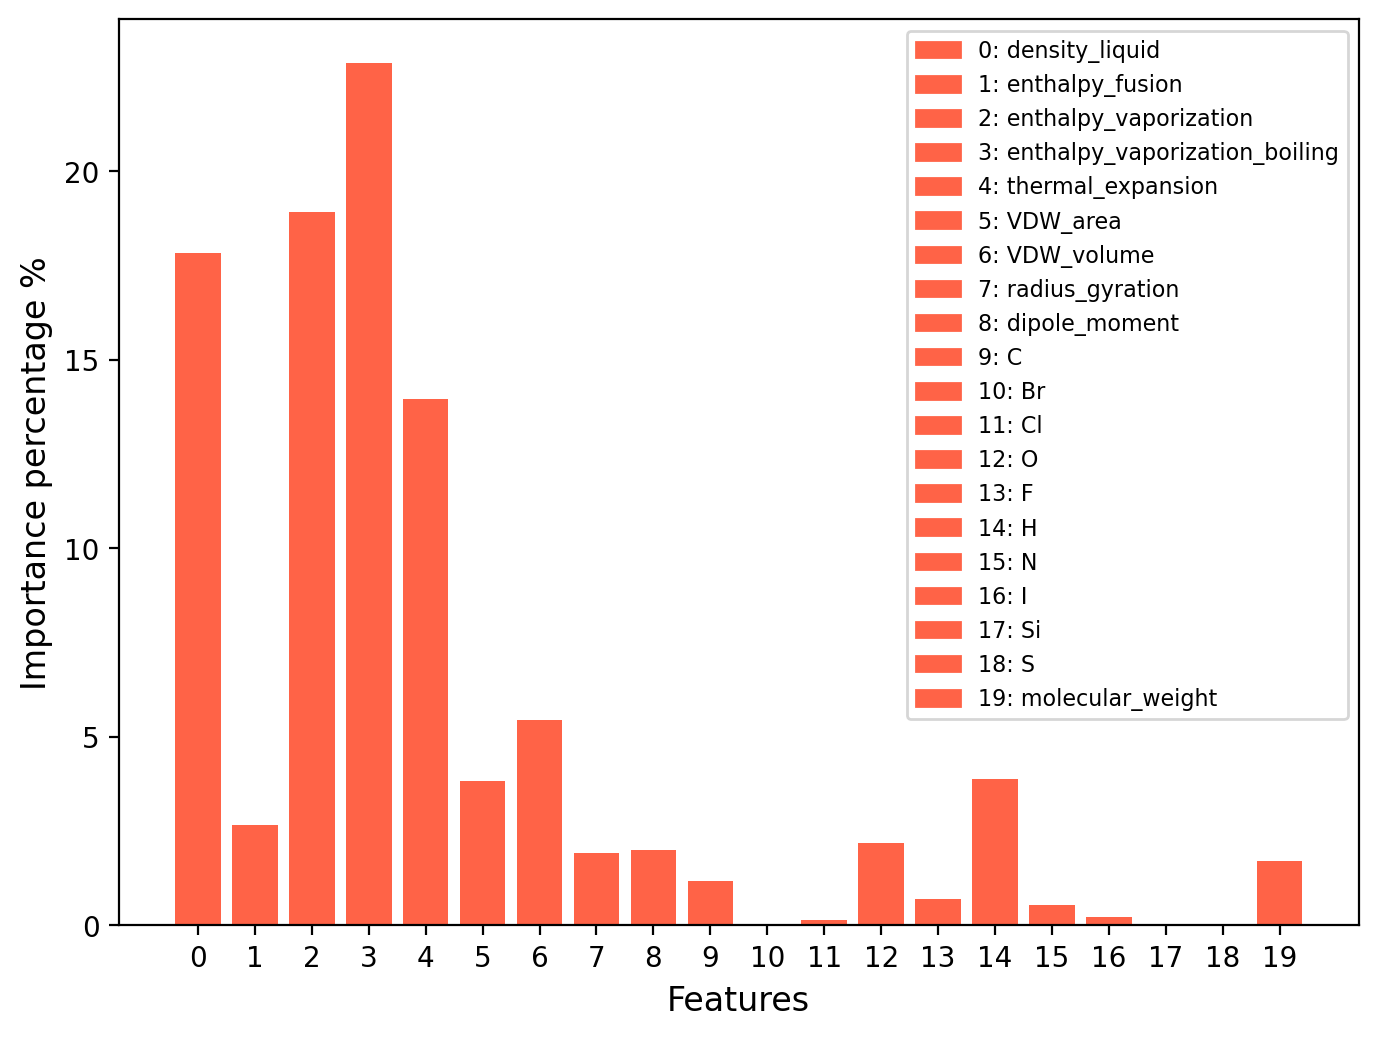

In [161]:
algorithm_name = 'rf'
hist = compute_percentual_importance(result)
labels = plot_feature_importance(hist, data_select, all_data[data_select], algorithm_name)

In [12]:
def sorted_dict(result, labels, k):
    std_dic ={}
    for i in range(len(result.importances_mean)):
        std_dic[labels[i]] = result.importances_mean[i]
    std_dic = dict(sorted(std_dic.items(), key=lambda item: item[1]))
    list_sort = list(std_dic.keys())[0:k]
    return list_sort

def best_feature_data_set(data, best_features):
    best_features = ["surface_tension"] + best_features
    best_features_data = data[best_features]
    return best_features_data

In [13]:
best_features = sorted_dict(result, labels, k=k)
data_set = best_feature_data_set(all_data[data_select], best_features)
data_set

,surface_tension,P,Ga,B,Al,Si,Br,I,S,Cl,F,N,enthalpy_vaporization_boiling,O,C,molecular_weight
0,13.03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,22.372,0.0,1.0,165.363946
1,29.95,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,32.156,0.0,1.0,198.272940
2,3.76,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,17.531,0.0,1.0,148.909449
3,17.10,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,26.653,0.0,1.0,209.814546
4,21.53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,26.857,0.0,1.0,61.470343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4165,12.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,63.510,0.0,33.0,479.909052
4166,15.55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.867,0.0,34.0,478.921030
4167,11.94,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.361,0.0,36.0,506.974274
4168,10.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,65.490,0.0,36.0,521.988918


In [14]:
rfr = FeatureRandomForest()
X_train, X_test, y_train, y_test = rfr.split(data_set)
hyperparameters = {'max_features': ["sqrt","log2"],
                  'n_estimators': [int(x) for x in np.linspace(start=1, stop=50, num=5)],
                  'max_depth': [int(x) for x in np.linspace(1, 110, num=5)],
                  'min_samples_split': [2, 4, 5, 6],
                  'min_samples_leaf': [1, 2, 4, 8],
                  "bootstrap": [True]}
best_params = rfr.search(hyperparameters, X_train, y_train)
model = rfr.best_regresor(best_params, X_train, y_train)
result = rfr.feature_importance(model,  X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=-0.004 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.004 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.035 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=-0.001 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.047 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=13;, score=0.108 total time=   0.0s
[CV 2/5] END bootstrap=True, max_

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.100 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.086 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.091 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.047 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=-0.007 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.107 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=1, min_samples_

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.094 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.074 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.062 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.043 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.048 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.074 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_s

[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.067 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=-0.009 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.037 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.059 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.021 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.119 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=2, min_samples_split

[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.086 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.106 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.084 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.100 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.039 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.112 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.109 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.087 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.118 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.037 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.092 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.106 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=4, min_samples_s

[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.112 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.100 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.011 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=-0.000 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.012 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.028 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=sqrt, min_samples_leaf=8, min_samples_spli

[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.076 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.036 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.036 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.082 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.045 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=37;, score=0.088 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_s

[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.034 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.014 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.073 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.078 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.088 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.039 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=1, min_samples_s

[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.033 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=-0.005 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.055 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.034 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=-0.001 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=13;, score=0.090 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_spli

[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.069 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.075 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.040 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.051 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.088 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.078 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=2, min_samples_s

[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.077 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.040 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.098 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.093 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.097 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.035 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=4, min_samples_sp

[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=25;, score=0.097 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=37;, score=0.083 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=37;, score=0.035 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=37;, score=0.097 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=37;, score=0.100 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=37;, score=0.109 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_s

[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=37;, score=0.099 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.103 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.036 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.090 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.103 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=50;, score=0.097 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=1, max_features=log2, min_samples_leaf=8, min_samples_s

[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.275 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=-1.106 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.362 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=1;, score=0.453 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=13;, score=0.722 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=13;, score=0.315 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_sampl

[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=13;, score=0.309 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=13;, score=0.130 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=13;, score=0.717 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=13;, score=0.688 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=25;, score=0.726 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=25;, score=0.318 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=25;, score=0.701 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=25;, score=0.289 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=25;, score=0.595 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=25;, score=0.699 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=25;, score=0.673 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=37;, score=0.713 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 5/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.655 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.689 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.292 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.583 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.707 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.656 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.650 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.270 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.619 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.657 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.635 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1;, score=0.470 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=4, min_sam

[CV 4/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=13;, score=0.618 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=13;, score=0.578 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=25;, score=0.558 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=25;, score=0.239 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=25;, score=0.586 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=25;, score=0.627 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=25;, score=0.568 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=25;, score=0.599 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=25;, score=0.580 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=37;, score=0.573 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=37;, score=0.255 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=37;, score=0.561 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=sqrt, min_samples_leaf=8, min_sa

[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=37;, score=0.368 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=37;, score=0.701 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=37;, score=0.687 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.737 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.329 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.159 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.441 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.730 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.691 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.552 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.231 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.253 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=1, min_sampl

[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=13;, score=0.280 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=13;, score=0.564 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=13;, score=0.690 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=13;, score=0.671 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=25;, score=0.701 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=25;, score=0.300 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.697 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.297 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.625 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.721 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.659 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.706 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.660 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.286 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.596 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.663 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.625 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.658 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.274 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.597 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.662 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.644 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1;, score=0.169 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_samples_split=2, n_estimators=1;, score=0.229 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_samp

[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=13;, score=0.577 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=13;, score=0.572 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=25;, score=0.570 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=25;, score=0.263 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=25;, score=0.583 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=25;, score=0.610 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=28, max_features=log2, min_samples_leaf=8, min_sa

[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.686 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=37;, score=0.745 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=37;, score=0.311 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=37;, score=0.364 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=37;, score=0.698 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=37;, score=0.669 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.735 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.334 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.392 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.686 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_samples_split=6, n_estimators=1;, score=0.546 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=1, min_sam

[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.686 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.552 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.121 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.447 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=-0.313 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=-0.215 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_sampl

[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.694 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.291 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.606 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.696 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=25;, score=0.666 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=37;, score=0.698 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.657 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.276 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.612 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.649 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.601 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=0.654 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.662 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.278 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.597 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.669 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.638 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=1;, score=0.443 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_sam

[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.578 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.177 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.114 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.315 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.069 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.410 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=8, min_samples

[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=13;, score=0.655 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=13;, score=0.683 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.732 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.319 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.363 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.706 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.724 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.331 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.449 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.727 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.666 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=50;, score=0.725 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.711 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.310 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.536 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.723 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.664 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=4, n_estimators=1;, score=0.445 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_sam

[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.674 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.481 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.158 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.554 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.499 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.305 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=2, min_samples

[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.285 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.595 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.648 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.642 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.651 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.278 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_sa

[CV 3/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.592 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.678 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.622 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.656 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.276 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.591 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=4, min_sa

[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.606 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.587 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.490 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.198 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.265 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.344 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=log2, min_samples_leaf=8, min_sample

[CV 5/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=13;, score=0.681 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.724 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.324 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=-0.146 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.689 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.675 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_s

[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.717 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.686 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.722 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.326 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.367 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.736 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=1, min_sa

[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.596 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.720 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.674 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.677 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.295 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=0.584 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_sa

[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.632 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.712 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.672 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.415 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.251 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.485 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=2, min_sampl

[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.271 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.635 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.675 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=25;, score=0.630 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.652 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=37;, score=0.280 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.660 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.289 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.611 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.662 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.637 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=0.650 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=4, min_sa

[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.602 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.240 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.550 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.625 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.575 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=1;, score=0.373 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=sqrt, min_samples_leaf=8, min_sam

[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=13;, score=0.330 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=13;, score=0.117 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=13;, score=0.718 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=13;, score=0.656 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.743 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=25;, score=0.308 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_sa

[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.717 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.322 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.378 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.723 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=25;, score=0.667 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=37;, score=0.732 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=1, min_sa

[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.657 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.694 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.302 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.563 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.721 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.668 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_sa

[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.696 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.297 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.615 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.711 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=50;, score=0.667 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_samples_split=6, n_estimators=1;, score=0.430 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=2, min_sam

[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.639 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1;, score=0.265 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1;, score=0.196 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1;, score=0.553 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1;, score=0.532 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=1;, score=0.382 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples

[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=25;, score=0.659 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=25;, score=0.287 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=25;, score=0.616 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=25;, score=0.661 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=25;, score=0.615 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=37;, score=0.655 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=4, min_sa

[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=37;, score=0.255 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=37;, score=0.557 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=37;, score=0.608 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=37;, score=0.551 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.610 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.253 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_sa

[CV 1/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.610 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.248 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.562 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.626 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=82, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.582 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.499 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_s

[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.688 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.515 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.230 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.500 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.509 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.246 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=1, min_

[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.706 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.307 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.654 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.712 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.661 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.656 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2,

[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=0.644 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.709 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.285 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.590 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.714 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.649 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=2,

[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.661 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.269 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.608 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.662 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.631 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=4, n_estimators=1;, score=0.462 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, 

[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=13;, score=0.635 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=13;, score=0.617 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=25;, score=0.644 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=25;, score=0.271 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=25;, score=0.614 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=25;, score=0.668 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=4,

[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=37;, score=0.251 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=37;, score=0.579 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=37;, score=0.620 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=37;, score=0.606 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.581 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=4, n_estimators=50;, score=0.252 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8,

[CV 1/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.582 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.251 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.539 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.615 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=sqrt, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.567 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=1;, score=0.437 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, 

[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=0.686 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.473 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.336 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.247 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.435 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=1;, score=0.562 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=1, min_

[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.681 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.306 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.658 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.719 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=25;, score=0.654 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=37;, score=0.706 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=25;, score=0.663 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.711 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.308 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.591 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.705 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=37;, score=0.656 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=2,

[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=37;, score=0.632 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.645 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.284 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.613 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.681 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=0.632 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4,

[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=0.636 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.501 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.164 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.327 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.443 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=1;, score=0.517 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=4, min_

[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=13;, score=0.618 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=13;, score=0.578 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=25;, score=0.579 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=25;, score=0.257 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=25;, score=0.547 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=4, n_estimators=25;, score=0.599 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8,

[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=37;, score=0.253 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=37;, score=0.544 total time=   0.0s
[CV 4/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=37;, score=0.596 total time=   0.0s
[CV 5/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=37;, score=0.573 total time=   0.0s
[CV 1/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.596 total time=   0.0s
[CV 2/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8, min_samples_split=6, n_estimators=50;, score=0.248 total time=   0.0s
[CV 3/5] END bootstrap=True, max_depth=110, max_features=log2, min_samples_leaf=8,

In [15]:
def metrics(model, X_train, X_test, y_train, y_test):
    r2_score_train = []
    mse_score_train = []
    r2_score_test = []
    mse_score_test = []
    y_train_pred = model.predict(X_train)
    mse_score_train.append(mean_squared_error(y_train, y_train_pred))
    r2_score_train.append(r2_score(y_train, y_train_pred))
    y_pred = model.predict(X_test)
    mse_score_test.append(mean_squared_error(y_test, y_pred))
    r2_score_test.append(r2_score(y_test, y_pred))    
    return r2_score_train, mse_score_train, r2_score_test, mse_score_test

def plot_performances(r2_score_train, mse_score_train, r2_score_test, mse_score_test, data_set_number, file_name, k=None):
    fig, axs = plt.subplots(1, 2)
    if data_set_number == 0:
        color_1 = "tomato"
    elif data_set_number == 1:
        color_1 = "gold"
    elif data_set_number == 2:
        color_1 = "#02faa3"
    elif data_set_number == 3:
        color_1 = "#2a4359"
    x_labels_r2 = ["R_2 Score with train data", "R_2 Score with test data"]
    values_r2 = r2_score_train + r2_score_test
    axs[0].bar(x_labels_r2, values_r2, color=color_1)
    axs[0].set(
        xlabel="Type of Data", 
        title=f"R_2 Score with data set {data_set_number}", 
    )
    x_labels_mse = ["MSE Score with train data", "MSE Score with test data"]
    values_mse = mse_score_train + mse_score_test
    axs[1].bar(x_labels_mse, values_mse, color=color_1)
    axs[1].set(
        xlabel="Type of Data", 
        title=f"MSE Score with data set {data_set_number}", 
    )
    fig.set(figwidth=15, dpi=100)
    if file_name is not None:
        fig.savefig(f"score performances with {k} best feature over the data set {data_set_number}")
    return axs

In [16]:
r2_score_train, mse_score_train, r2_score_test, mse_score_test = metrics(model, X_train, X_test, y_train, y_test)

array([<AxesSubplot:title={'center':'R_2 Score with data set 3'}, xlabel='Type of Data'>,
       <AxesSubplot:title={'center':'MSE Score with data set 3'}, xlabel='Type of Data'>],
      dtype=object)

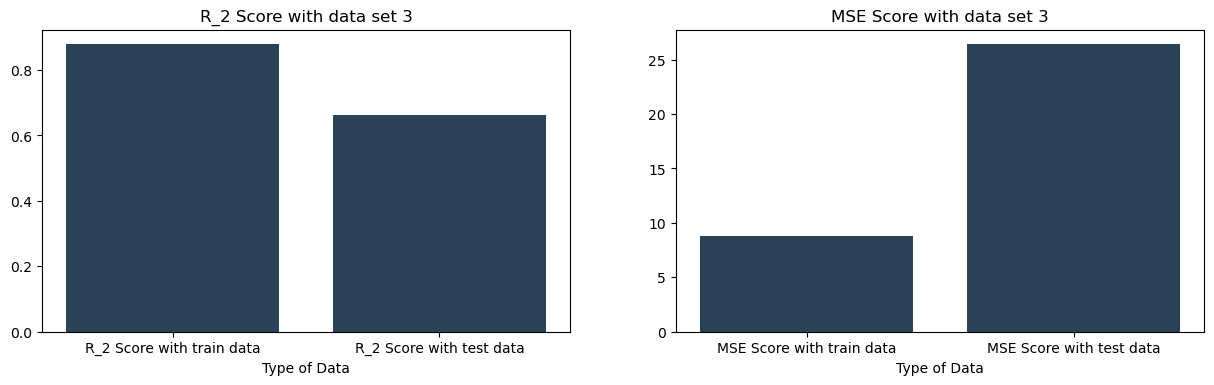

In [17]:
plot_performances(r2_score_train, mse_score_train, r2_score_test, mse_score_test, data_select, True, k=k)